<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0804new%5D_machine_learning_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM (20개 과거 → 5개 미래)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터 생성
np.random.seed(42)
days = 90
points_per_day = 24 * 12

# 복잡한 데이터
# 1. 데이터 생성
np.random.seed(42)
total_points = days * points_per_day
theta = np.linspace(0, 30 * np.pi, total_points)

# 복합 파형 구성
mix_wave = (
    0.6 * np.sin(theta) +
    0.3 * sawtooth(theta * 0.7) +
    0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
    np.random.normal(0, 0.1, total_points)
)

mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

# ✅ 비선형 트렌드 수정
# 앞부분 감소 → 중간 유지 → 끝부분 증가 형태로 설계
# 구간별로 조합
x = np.linspace(0, 1, total_points)
trend = np.piecewise(x,
    [x < 0.3, (x >= 0.3) & (x < 0.7), x >= 0.7],
    [
        lambda x: -10 * x,               # 앞부분 감소
        lambda x: -3,                    # 중간 유지
        lambda x: 20 * (x - 0.7)**1.5    # 끝부분 우상향 (가속 곡선)
    ]
)

# 최종 CPU 시계열
cpu = 60 + 40 * mix_wave + trend


# 단순한 데이터
# total_points = days * points_per_day
# cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)


time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

scaler = MinMaxScaler()
cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

past_steps = 20
future_steps = 5

# ✅ 데이터 분할 (80:10:10)
n_total = len(cpu_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

cpu_train = cpu_scaled.iloc[:n_train]
cpu_val   = cpu_scaled.iloc[n_train:n_train + n_val]
cpu_test  = cpu_scaled.iloc[n_train + n_val:]

# ✅ 시퀀스 생성 함수
def create_sequences(data, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data.iloc[i:i+past_steps].values)
        y.append(data.iloc[i+past_steps:i+past_steps+future_steps].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(cpu_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(cpu_val, past_steps, future_steps)
X_test,  y_test  = create_sequences(cpu_test, past_steps, future_steps)

# ✅ 모델 정의 및 학습 (validation 포함)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train.reshape((y_train.shape[0], -1)),
    epochs= 1,
    batch_size=16,
    validation_data=(X_val, y_val.reshape((y_val.shape[0], -1))),
    verbose=1
)

# ✅ 테스트 예측 및 성능 평가
pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0209 - val_loss: 0.0024
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MAE : 4.980305683367335
RMSE: 6.509062531738308
R²  : 0.9394023989401846


CNN-LSTM
MAE : 4.980305683367335
RMSE: 6.509062531738308
R2: 0.9394023989401846


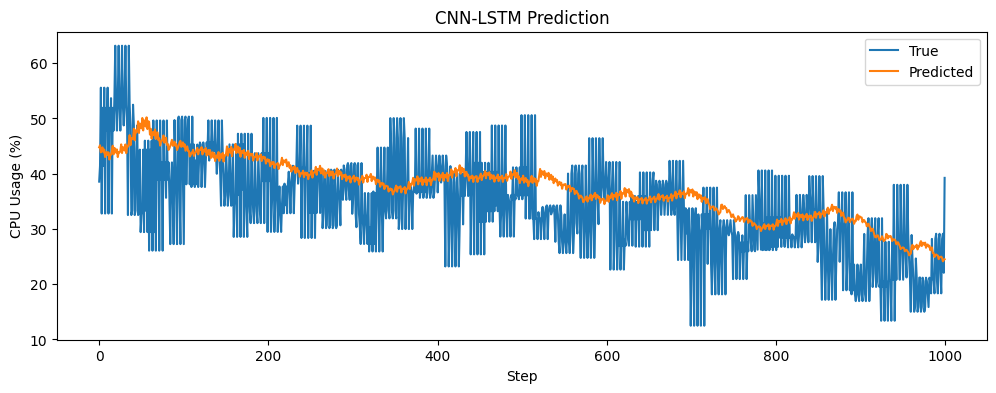

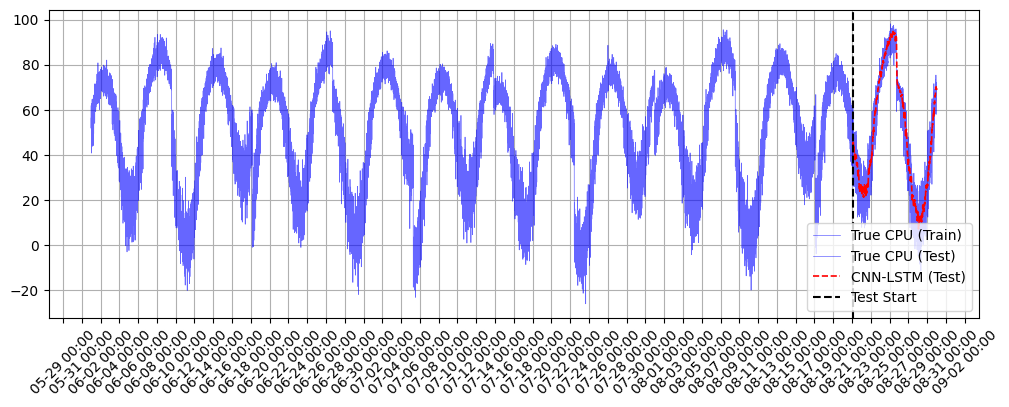

In [9]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
# full_time_index = df.index  # 전체 시간 index (x축)
# test_start_idx = len(X_train) + past_steps
# test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지
test_series_true= df['cpu'][test_start_idx:]

total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]


# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

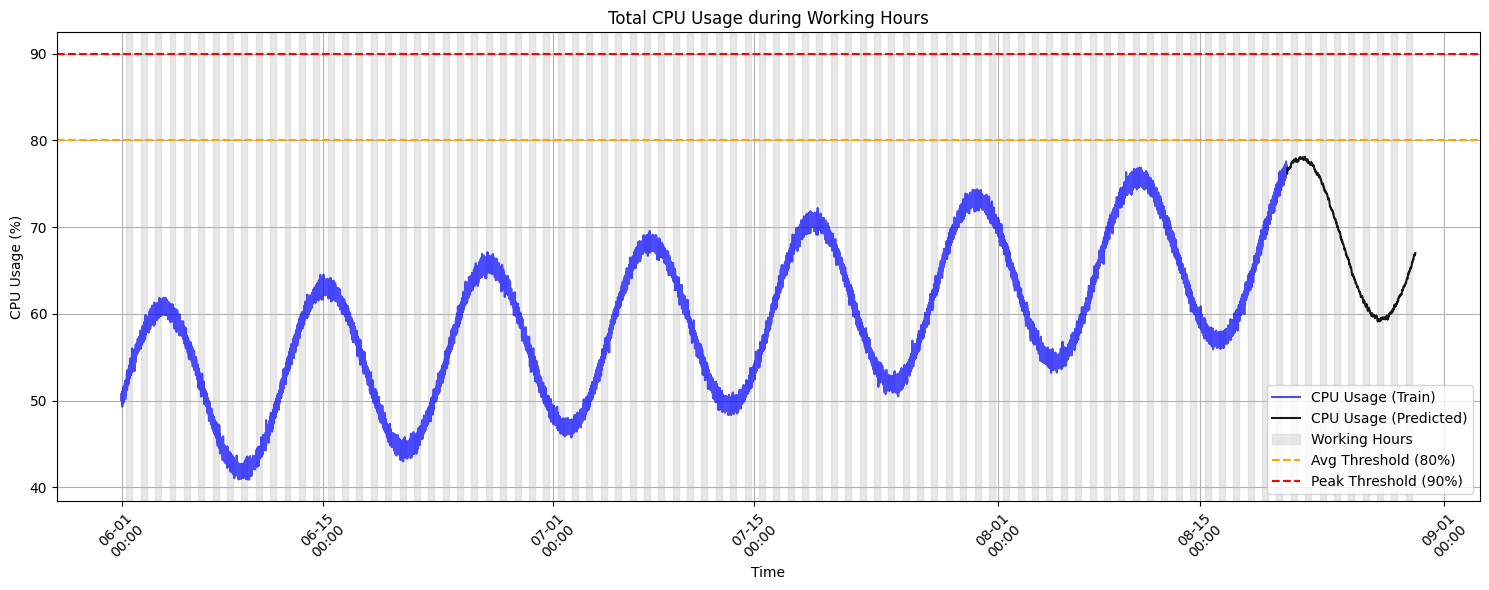

 Condition 1 (Avg CPU during working hours ≥ 80%): False (60.00%)
 Condition 2 (≥80% of days with peak > 90%): False (0/90)
 Final Upgrade Decision:  No Upgrade Required


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "cpu_pred"

# 2. 업무시간 (08:00~18:00)만 추출
work_time = all_pred_series.between_time("08:00", "18:00")

# 3. 조건 1: 업무시간 평균 CPU 사용률 ≥ 80%
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold

# 4. 조건 2: 업무시간 중 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold).between_time("08:00", "18:00")
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Test 구간
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# 업그레이드 신호 표시
if len(upgrade_times) > 0:
    ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()


# 8. 결과 출력
print(f" Condition 1 (Avg CPU during working hours ≥ 80%): {condition1_flag} ({work_time.mean():.2f}%)")
print(f" Condition 2 (≥80% of days with peak > 90%): {condition2_flag} ({peak_days}/{total_days})")
print(f" Final Upgrade Decision: {'Upgrade Needed' if upgrade_flag else ' No Upgrade Required'}")


In [11]:
# streamlit 위한 csv 저장
import json
with open("cpu_accuracy_metrics_CNN-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN-LSTM.csv") # 전체 cpu
test_series_pred.to_csv("cpu_usage_predicted_only_CNN-LSTM.csv") # 예측 구간 cpu
work_time.to_csv("cpu_usage_working_hours_CNN-LSTM.csv") # 업무시간 cpu
daily_peak.to_csv("cpu_peak_flag_per_day_CNN-LSTM.csv") # peak 발생 여부

with open("upgrade_decision_CNN-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")

!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install streamlit

## 기준 따라서 증설 시점 정하기

average CPU :  59.94489


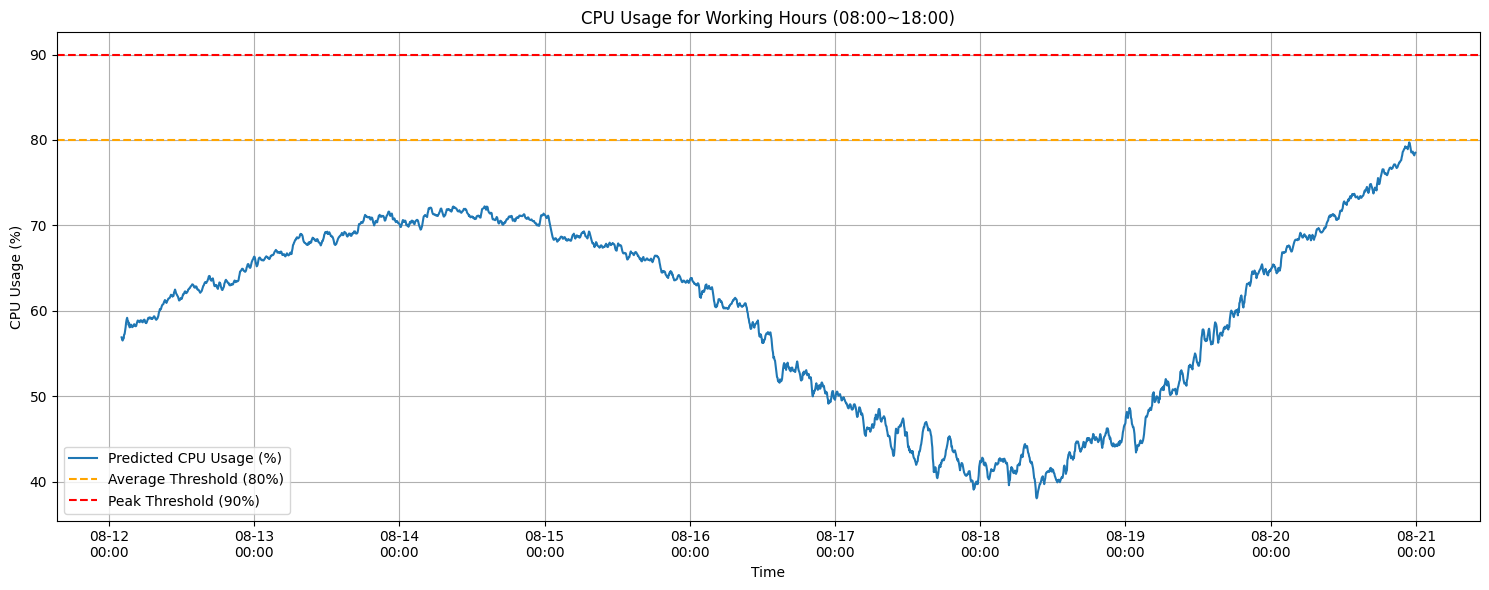

✅ Condition 1 (Avg CPU during working hours ≥ 80%): False
✅ Condition 2 (≥5 days with peak > 90% during working hours): False
🔍 Final Upgrade Decision: 🟩 No Upgrade Required


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 업무시간 필터링
test_time_index = df.index[split_point + past_steps + future_steps : split_point + past_steps + future_steps + len(pred_inv)]
time_series = pd.Series(pred_inv.mean(axis=1), index=test_time_index)
work_time = time_series.between_time("08:00", "18:00")

# 조건 1: 전체 업무시간 평균이 80% 이상 ---
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold
print("average CPU : ", work_time.mean() )

# 조건 2: 업무시간 내 피크가 매일 1회 이상 발생한 날이 80% 이상 ---
peak_threshold = 90
work_peak_flags = pd.Series((pred_inv > peak_threshold).any(axis=1), index=test_time_index).between_time("08:00", "18:00")

# 피크가 발생했는지 여부
daily_peak = work_peak_flags.groupby(work_peak_flags.index.date).any()

# 전체 일 수 중 피크가 발생한 비율이 80% 이상인지
total_days = len(daily_peak)
peak_days = daily_peak.sum()
condition2_flag = (peak_days / total_days) >= 0.8

# 조건1,2 교집합으로 판단
upgrade_flag = condition1_flag or condition2_flag

# 증설 타이밍 시각화용 표시
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    peak_days = daily_peak_count[daily_peak_count >= 1].index[:5]  # 처음 5일만 표시
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_days.astype(str))].index
else:
    upgrade_times = []

plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label="Predicted CPU Usage (%)")
plt.axhline(avg_threshold, color='orange', linestyle='--', label="Average Threshold (80%)")
plt.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")
if len(upgrade_times) > 0:
    plt.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5)
plt.title("CPU Usage for Working Hours (08:00~18:00)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.tight_layout()
plt.show()

# 결과 출력
print(f"✅ Condition 1 (Avg CPU during working hours ≥ 80%): {condition1_flag}")
print(f"✅ Condition 2 (≥5 days with peak > 90% during working hours): {condition2_flag}")
print(f"🔍 Final Upgrade Decision: {'🟥 Upgrade Needed' if upgrade_flag else '🟩 No Upgrade Required'}")


🚨 Upgrade Timing Detected: 2025-06-15 08:00:00


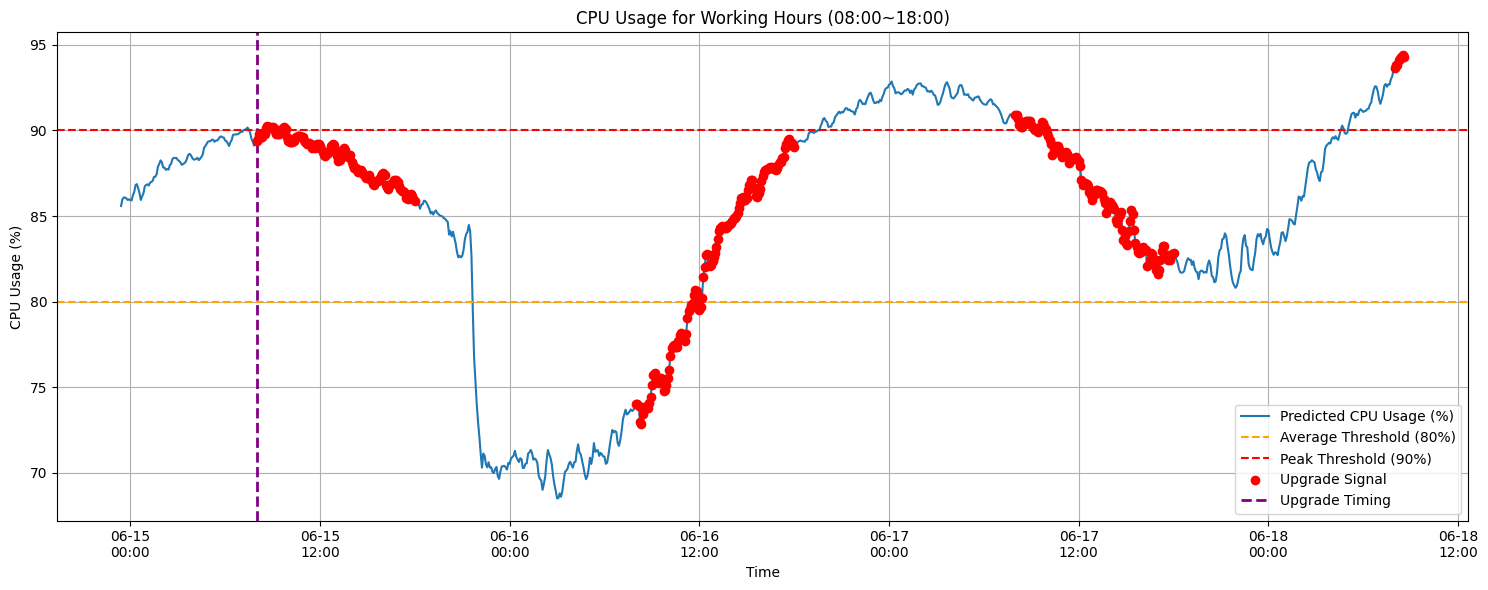

In [ ]:
# --- ✅ 증설 시점 판단 (처음 조건 만족한 시점 하나만 추출) ---
if len(upgrade_times) > 0:
    upgrade_time_final = upgrade_times[0]  # 첫 번째 발생 시점
    print(f"🚨 Upgrade Timing Detected: {upgrade_time_final}")
else:
    upgrade_time_final = None
    print("✅ No upgrade timing detected.")

# 시각화 (기존 코드 유지)
plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label="Predicted CPU Usage (%)")
plt.axhline(avg_threshold, color='orange', linestyle='--', label="Average Threshold (80%)")
plt.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")
if len(upgrade_times) > 0:
    plt.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5)

# ✅ 첫 증설 시점을 선으로 시각화
if upgrade_time_final:
    plt.axvline(x=upgrade_time_final, color='purple', linestyle='--', linewidth=2, label='Upgrade Timing')

plt.title("CPU Usage for Working Hours (08:00~18:00)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.tight_layout()
plt.show()


## 2. 단순 CNN

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from scipy.signal import sawtooth


# 복잡한 데이터
# 1. 데이터 생성
np.random.seed(42)
days = 90
points_per_day = 24 * 12
total_points = days * points_per_day
theta = np.linspace(0, 30 * np.pi, total_points)

# 복합 파형 구성
mix_wave = (
    0.6 * np.sin(theta) +
    0.3 * sawtooth(theta * 0.7) +
    0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
    np.random.normal(0, 0.1, total_points)
)

mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

# ✅ 비선형 트렌드 수정
# 앞부분 감소 → 중간 유지 → 끝부분 증가 형태로 설계
# 구간별로 조합
x = np.linspace(0, 1, total_points)
trend = np.piecewise(x,
    [x < 0.3, (x >= 0.3) & (x < 0.7), x >= 0.7],
    [
        lambda x: -10 * x,               # 앞부분 감소
        lambda x: -3,                    # 중간 유지
        lambda x: 20 * (x - 0.7)**1.5    # 끝부분 우상향 (가속 곡선)
    ]
)

# 최종 CPU 시계열
cpu = 60 + 40 * mix_wave + trend


time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

scaler = MinMaxScaler()
cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

# 정규화는 train만 fit
split_point = int(len(cpu_scaled) * 0.8)
df_train = cpu_scaled.iloc[:split_point]
df_test = cpu_scaled.iloc[split_point:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test 시퀀스 구성
X_train, y_train = create_sequences(df_train, past_steps, future_steps)

# test는 train 마지막 20개와 test 앞부분을 이어붙여 구성
# test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
# X_test, y_test = create_sequences(test_base, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# CNN-only 모델
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0127
Epoch 2/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0026
Epoch 3/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0026
Epoch 4/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0025
Epoch 5/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0025
Epoch 6/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0025
Epoch 7/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0025
Epoch 8/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0024
Epoch 9/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0025
Epoch 10/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0025
Epoch 11/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0024
Epoch 12/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0025
Epoch 13/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0024
Epoch 14/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0024
Epoch 15/50
1295/1295 ━━━━━━━

CNN
MAE : 4.980305683367335
RMSE: 6.509062531738308
R²  : 0.9394023989401846


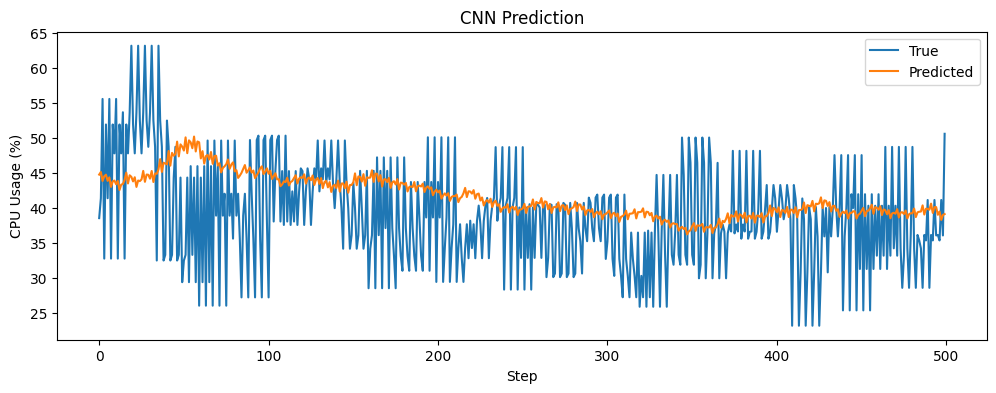

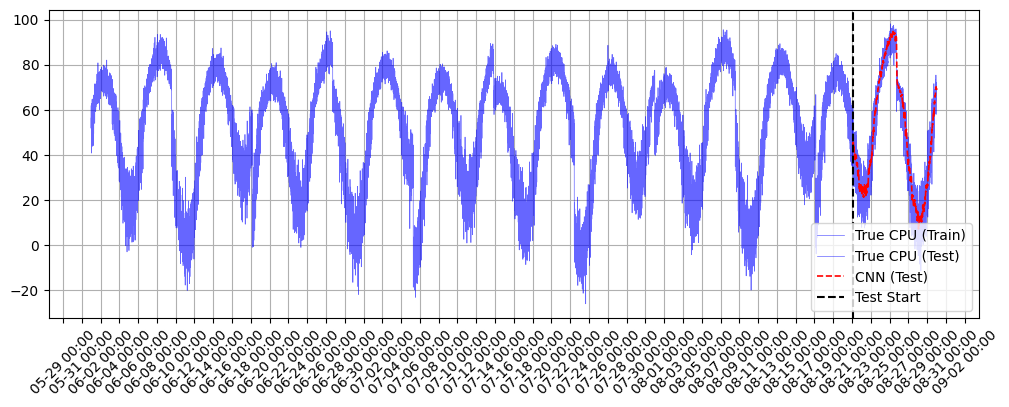

In [10]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
# full_time_index = df.index  # 전체 시간 index (x축)
# test_start_idx = len(X_train) + past_steps
# test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
# train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지
test_series_true= df['cpu'][test_start_idx:]

total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5



# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

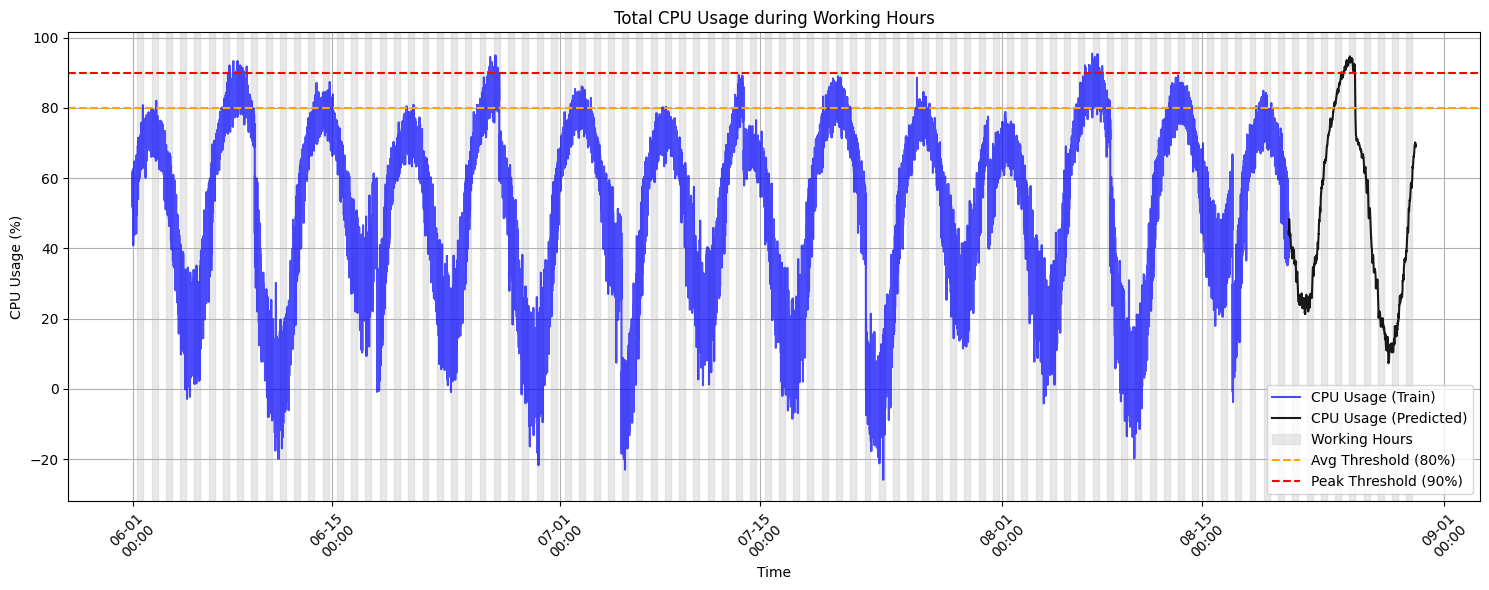

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "cpu_pred"

# 2. 업무시간 (08:00~18:00)만 추출
work_time = all_pred_series.between_time("08:00", "18:00")

# 3. 조건 1: 업무시간 평균 CPU 사용률 ≥ 80%
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold

# 4. 조건 2: 업무시간 중 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold).between_time("08:00", "18:00")
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Test 구간
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# 업그레이드 신호 표시
if len(upgrade_times) > 0:
    ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()


In [6]:
# streamlit 위한 csv 저장
import json
with open("cpu_accuracy_metrics_CNN2.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_CNN2.csv") # 전체 cpu
test_series_pred.to_csv("cpu_usage_predicted_only_CNN2.csv") # 예측 구간 cpu
work_time.to_csv("cpu_usage_working_hours_CNN2.csv") # 업무시간 cpu
daily_peak.to_csv("cpu_peak_flag_per_day_CNN2.csv") # peak 발생 여부

with open("upgrade_decision_CNN2.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")

!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.6 MB/s eta 0:00:00


## 3. CNN-LSTM + Autoregressive , (20개 과거 → 1개 미래)를 반복해 하나씩 예측

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 1. 데이터 생성
np.random.seed(42)
days = 30
points_per_day = 24 * 12  # 5분 간격
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + \
      np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# 2. 정규화
scaler = MinMaxScaler()
cpu_scaled = pd.DataFrame(scaler.fit_transform(df[['cpu']]), index=df.index, columns=['cpu'])

# 3. train/test 분할
split_point = int(len(cpu_scaled) * 0.8)
df_train = cpu_scaled.iloc[:split_point]
df_test = cpu_scaled.iloc[split_point:]

# 4. 시퀀스 생성 함수
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps].values)
        y.append(dataset[i+past_steps:i+past_steps+future_steps].values)
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

X_train, y_train = create_sequences(df_train, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# 5. CNN-LSTM 모델 정의
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# 6. 학습 (reshape 필요)
model.fit(X_train.reshape((-1, past_steps, 1)),
          y_train.reshape((y_train.shape[0], -1)),
          epochs=10, batch_size=16, verbose=1)

# 7. Autoregressive 방식으로 예측
test_base = np.concatenate([df_train[-past_steps:], df_test])  # context 추가
preds, truths = [], []

for i in range(0, len(test_base) - past_steps - future_steps):
    input_seq = test_base[i:i+past_steps].values.reshape(1, past_steps, 1)
    pred_seq = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        pred_seq.append(pred[0][0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0][0]]]], axis=1)
    preds.append(pred_seq)
    truths.append(test_base[i+past_steps:i+past_steps+future_steps].values.flatten())

preds_inv = scaler.inverse_transform(np.array(preds))
truths_inv = scaler.inverse_transform(np.array(truths))

# 8. 성능 평가
print("CNN-LSTM (Autoregressive)")
print("MAE :", mean_absolute_error(truths_inv, preds_inv))
print("RMSE:", np.sqrt(mean_squared_error(truths_inv, preds_inv)))
print("R²  :", r2_score(truths_inv, preds_inv))

# 9. 시각화: 예측 일부
plt.figure(figsize=(12, 4))
plt.plot(truths_inv[:500].flatten(), label="True")
plt.plot(preds_inv[:500].flatten(), label="Predicted")
plt.title("CNN-LSTM (Autoregressive) Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

# 10. 시각화: 전체 시계열 기반 그래프
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx:test_start_idx + len(truths)]
train_series = df['cpu'][:test_start_idx]
test_series_true = pd.Series(truths_inv.flatten(), index=test_time_index)

# 예측 시계열 생성
all_future_times = []
all_future_preds = []
future_interval = 5

for i in range(len(test_time_index)):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(preds_inv[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": np.array(all_future_preds)})
pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'].values, index=pred_df_mean.index)

# 시각화
fig, ax = plt.subplots(figsize=(12, 4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0380
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.3442e-04
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2458e-04
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.1066e-04
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9646e-04
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.7966e-04
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.6901e-04
Epoch 8/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.7161e-04
Epoch 9/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8235e-04
Epoch 10/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.7309e-04


AttributeError: 'numpy.ndarray' object has no attribute 'values'

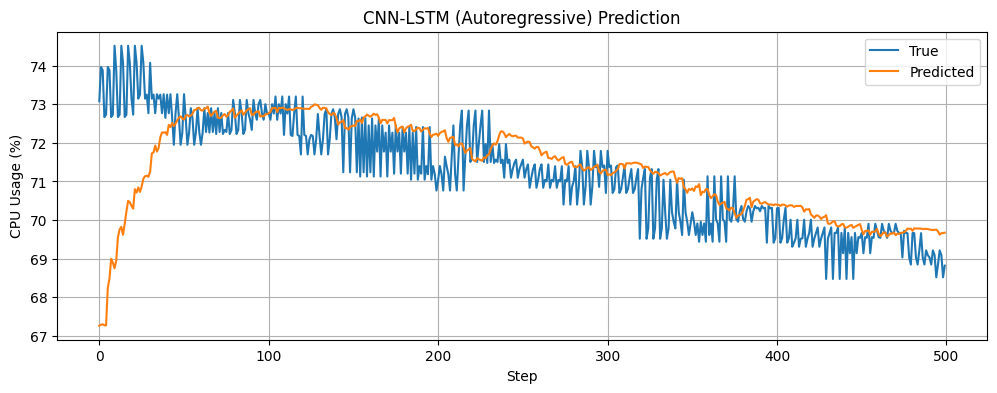

ValueError: Length of values (1723) does not match length of index (1708)

In [ ]:
# plot
# Plot 1: 예측 vs 실제
plt.figure(figsize=(12, 4))
plt.plot(truths_inv.flatten()[:500], label="True")
plt.plot(preds_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM (Autoregressive) Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 전체 시간 시계열 기반
test_start_idx = split_point + past_steps
# 필요한 인덱스 길이는 truths_inv와 동일하게 설정
test_time_index = df.index[test_start_idx : test_start_idx + len(truths_inv)]

# 그에 맞춰 시리즈 생성
test_series_true = pd.Series(truths_inv[:, 0], index=test_time_index)

train_series = df['cpu'][:test_start_idx]

# 예측 시계열 생성
all_future_times = []
all_future_preds = []
future_interval = 5

for i in range(len(test_time_index)):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(preds[i, j])

pred_df = pd.DataFrame({
    "time": all_future_times,
    "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()
})
pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index)

# 시각화
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Autoregressive)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.legend()
plt.grid(True)
plt.show()

# 성능 출력
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

## 4. FLNN + GA-PSO

In [17]:
# ========== FLNN 정의 ==========
def flnn_predict(w, X):
    return np.dot(X, w[:-1]) + w[-1]

def eval(ind):
    return (np.abs(flnn_predict(np.array(ind), X_train) - y_train).mean(),)

# GA 구성
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=past_steps+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval)

pop = toolbox.population(n=30)
pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, verbose=False)
best_ga = tools.selBest(pop, 1)[0]

# PSO
def pso_obj(w):
    return np.array([np.abs(flnn_predict(p, X_train) - y_train).mean() for p in w])

optimizer = ps.single.GlobalBestPSO(
    n_particles=20,
    dimensions=past_steps+1,
    options={'c1':1.5, 'c2':1.5, 'w':0.7},
    init_pos=np.tile(best_ga, (20, 1)) + np.random.normal(0, 0.1, (20, past_steps+1))
)
_, best_pso = optimizer.optimize(pso_obj, iters=100)

# 예측 및 복원
y_pred = flnn_predict(best_pso, X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# 평가 출력
print("FLNN-GA-PSO")
print("MAE :", mean_absolute_error(y_true_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_true_inv, y_pred_inv)))
print("R²  :", r2_score(y_true_inv, y_pred_inv))

# 시각화 (앞 500개)
plt.figure(figsize=(12, 4))
plt.plot(y_true_inv[:500], label="True")
plt.plot(y_pred_inv[:500], label="Predicted")
plt.title("FLNN-GA-PSO Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'creator' is not defined

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# 전체 시간 인덱스
full_time_index = df.index

# test 시작 위치 계산 (train 끝 + 슬라이딩 past_steps 보정)
test_start_idx = len(df_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

# Train 데이터 실제값 (복원 전 원래 값)
train_series = df['cpu'][:test_start_idx]

# Test 구간 실제값, 예측값 시리즈 생성
test_series_true = pd.Series(y_true_inv, index=test_time_index)
test_series_pred = pd.Series(y_pred_inv, index=test_time_index)

# 시각화
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="FLNN-GA-PSO (Predicted)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))  # 20시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.title("FLNN-GA-PSO Train + Test CPU Prediction")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (858, 1) instead

In [ ]:
y_train.shape

(6906,)

## 2. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

In [ ]:
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ✅ CNN-BiLSTM 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ✅ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ✅ 학습
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ✅ 예측
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ✅ 복원 (정규화 → 원래 단위 [%]로)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ✅ 성능 출력
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0151
Epoch 2/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0027
Epoch 3/20
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0025
Epoch 4/20
 990/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025

CNN-BiLSTM
MAE : 4.685040254056128
RMSE: 6.143161885117745
R2: 0.9460239592881177


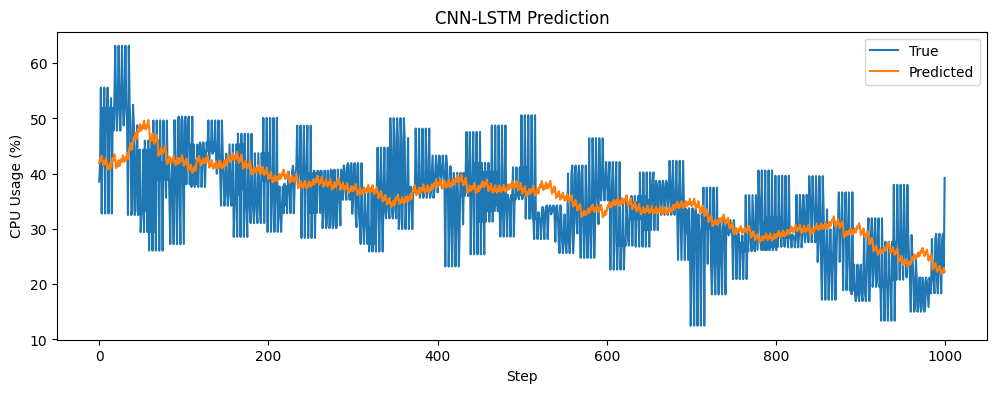

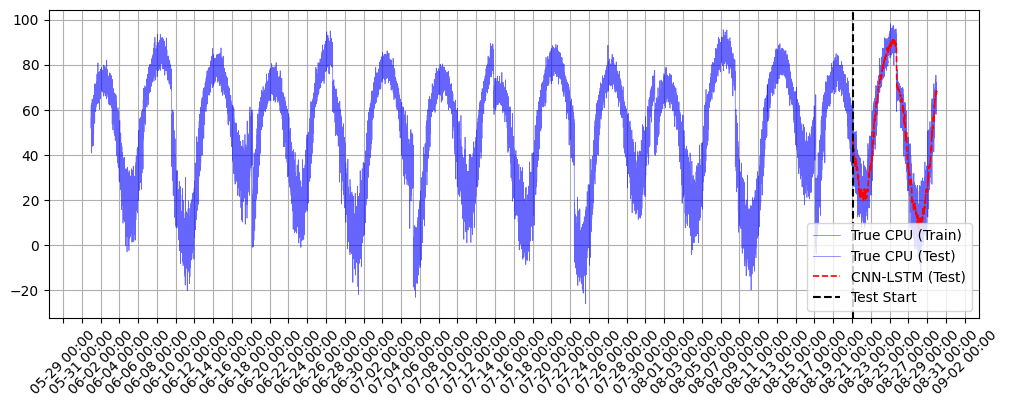

In [4]:
# plot

print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
# full_time_index = df.index  # 전체 시간 index (x축)
test_start_idx = len(X_train) + past_steps
# test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지
test_series_true= df['cpu'][test_start_idx:]

total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]


# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

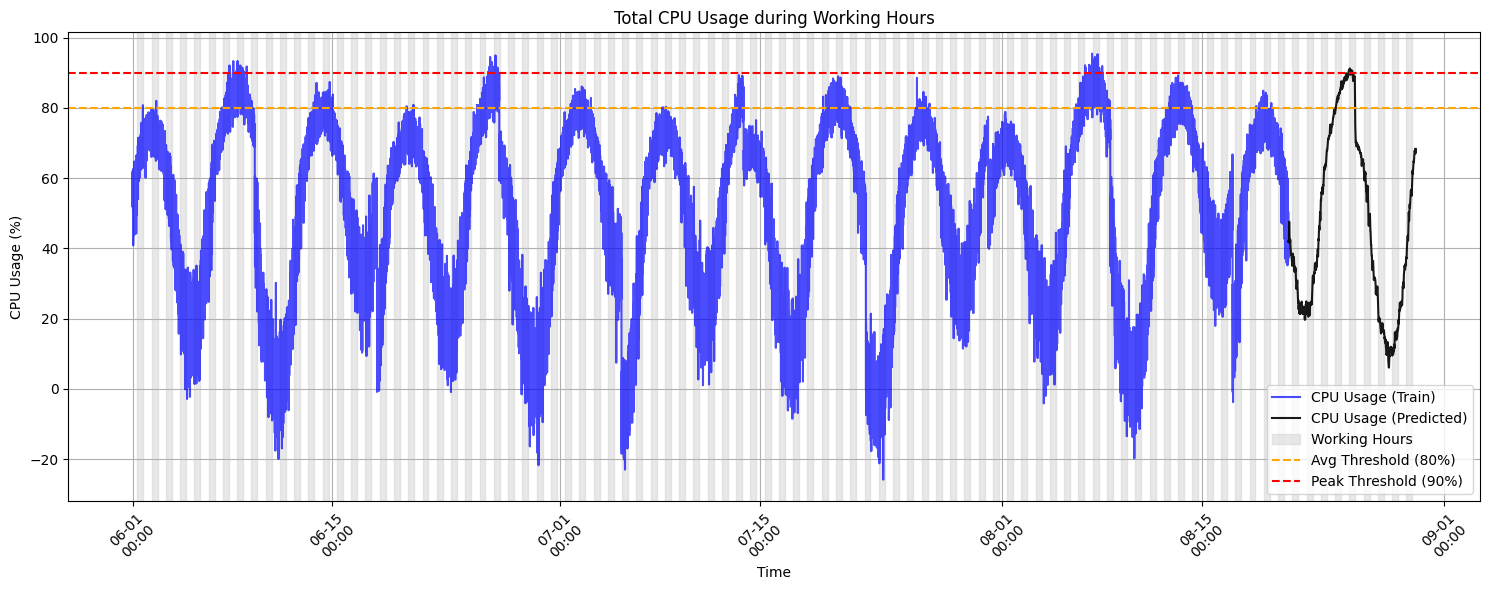

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "cpu_pred"

# 2. 업무시간 (08:00~18:00)만 추출
work_time = all_pred_series.between_time("08:00", "18:00")

# 3. 조건 1: 업무시간 평균 CPU 사용률 ≥ 80%
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold

# 4. 조건 2: 업무시간 중 피크(≥90%) 발생한 날이 전체의 80% 이상
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold).between_time("08:00", "18:00")
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Test 구간
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# 업그레이드 신호 표시
if len(upgrade_times) > 0:
    ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# 마무리 설정
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# streamlit 위한 csv 저장
import json
with open("cpu_accuracy_metrics_Bi-LSTM2.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series_Bi-LSTM2.csv") # 전체 cpu
test_series_pred.to_csv("cpu_usage_predicted_only_Bi-LSTM2.csv") # 예측 구간 cpu
work_time.to_csv("cpu_usage_working_hours_Bi-LSTM2.csv") # 업무시간 cpu
daily_peak.to_csv("cpu_peak_flag_per_day_Bi-LSTM2.csv") # peak 발생 여부

with open("upgrade_decision_Bi-LSTM2.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")

!pip install streamlit

## streamlit 실행 파일(app.py)

In [6]:
# @title

import os
import streamlit as st

# 1. 디렉토리 생성
os.makedirs("cpu_dashboard", exist_ok=True)

# 2. app.py 코드 문자열 (Streamlit 코드 전체 복사해서 여기에 붙여넣기)
code = '''import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
st.markdown("<h1 style='font-size:30px;'>📈 CPU 사용량 및 증설 판단</h1>", unsafe_allow_html=True)

# 이상적인 데이터

st.markdown("#### 1. 이상적인 데이터")

with st.expander("학습모델 : CNN-LSTM"):
    st.markdown("#### 학습모델 : CNN-LSTM ")

    # 데이터 불러오기
    df_all_ideal = pd.read_csv("all_series_CNN-LSTM.csv", index_col=0, parse_dates=True)
    df_pred_ideal = pd.read_csv("cpu_usage_predicted_only_CNN-LSTM.csv", index_col=0, parse_dates=True)
    df_work_ideal = pd.read_csv("cpu_usage_working_hours_CNN-LSTM.csv", index_col=0, parse_dates=True)
    df_peak_ideal = pd.read_csv("cpu_peak_flag_per_day_CNN-LSTM.csv", index_col=0, parse_dates=True)

    avg_threshold = 80
    peak_threshold = 90

    # 조건 재계산
    avg_cpu_ideal = df_work_ideal.values.mean()
    condition1_ideal = avg_cpu_ideal >= avg_threshold

    peak_days_ideal = df_peak_ideal.values.sum()
    total_days_ideal = len(df_peak_ideal)
    condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

    upgrade_ideal = condition1_ideal or condition2_ideal

    # 정확도
    with open("cpu_accuracy_metrics_CNN-LSTM.json", "r") as f:
        metrics_ideal = json.load(f)

    # 결과 표시
    st.markdown("#### 📊 예측 정확도")
    st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
    st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
    st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

    st.markdown("#### 🔍 증설 판단")
    st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (업무시간 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
    st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (피크 발생일 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

    result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
    st.markdown(f"<h3>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

    # 그래프
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    split_idx_ideal = df_pred_ideal.index[0]
    train_series_ideal = df_all_ideal[df_all_ideal.index < split_idx_ideal]
    test_series_ideal = df_pred_ideal.squeeze()

    ax2.plot(train_series_ideal.index, train_series_ideal.values, label="CPU Usage (Train)", color="blue", alpha=0.7)
    ax2.plot(test_series_ideal.index, test_series_ideal.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

    first = True
    for date in pd.to_datetime(df_all_ideal.index.date).unique():
        start = pd.Timestamp(f"{date} 08:00")
        end = pd.Timestamp(f"{date} 18:00")
        label = "Working Hours" if first else None
        ax2.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
        first = False

    ax2.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
    ax2.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

    ax2.set_title("Ideal CPU Usage with Working Hours")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("CPU Usage (%)")
    ax2.legend()
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="center")

    st.pyplot(fig2)

# CNN
with st.expander("학습모델 : CNN"):
    st.markdown("#### 학습모델 : CNN ")

    # 데이터 불러오기
    df_all_ideal = pd.read_csv("all_series_CNN.csv", index_col=0, parse_dates=True)
    df_pred_ideal = pd.read_csv("cpu_usage_predicted_only_CNN.csv", index_col=0, parse_dates=True)
    df_work_ideal = pd.read_csv("cpu_usage_working_hours_CNN.csv", index_col=0, parse_dates=True)
    df_peak_ideal = pd.read_csv("cpu_peak_flag_per_day_CNN.csv", index_col=0, parse_dates=True)

    avg_threshold = 80
    peak_threshold = 90

    # 조건 재계산
    avg_cpu_ideal = df_work_ideal.values.mean()
    condition1_ideal = avg_cpu_ideal >= avg_threshold

    peak_days_ideal = df_peak_ideal.values.sum()
    total_days_ideal = len(df_peak_ideal)
    condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

    upgrade_ideal = condition1_ideal or condition2_ideal

    # 정확도
    with open("cpu_accuracy_metrics_CNN.json", "r") as f:
        metrics_ideal = json.load(f)

    # 결과 표시
    st.markdown("#### 📊 예측 정확도")
    st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
    st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
    st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

    st.markdown("#### 🔍 증설 판단")
    st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (업무시간 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
    st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (피크 발생일 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

    result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
    st.markdown(f"<h3>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

    # 그래프
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    split_idx_ideal = df_pred_ideal.index[0]
    train_series_ideal = df_all_ideal[df_all_ideal.index < split_idx_ideal]
    test_series_ideal = df_pred_ideal.squeeze()

    ax2.plot(train_series_ideal.index, train_series_ideal.values, label="CPU Usage (Train)", color="blue", alpha=0.7)
    ax2.plot(test_series_ideal.index, test_series_ideal.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

    first = True
    for date in pd.to_datetime(df_all_ideal.index.date).unique():
        start = pd.Timestamp(f"{date} 08:00")
        end = pd.Timestamp(f"{date} 18:00")
        label = "Working Hours" if first else None
        ax2.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
        first = False

    ax2.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
    ax2.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

    ax2.set_title("Ideal CPU Usage with Working Hours")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("CPU Usage (%)")
    ax2.legend()
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="center")

    st.pyplot(fig2)

## Bi-LSTM
with st.expander("학습모델 : Bi-LSTM"):
    st.markdown("#### 학습모델 : Bi-LSTM ")

    # 데이터 불러오기
    df_all_ideal = pd.read_csv("all_series_Bi-LSTM.csv", index_col=0, parse_dates=True)
    df_pred_ideal = pd.read_csv("cpu_usage_predicted_only_Bi-LSTM.csv", index_col=0, parse_dates=True)
    df_work_ideal = pd.read_csv("cpu_usage_working_hours_Bi-LSTM.csv", index_col=0, parse_dates=True)
    df_peak_ideal = pd.read_csv("cpu_peak_flag_per_day_Bi-LSTM.csv", index_col=0, parse_dates=True)

    avg_threshold = 80
    peak_threshold = 90

    # 조건 재계산
    avg_cpu_ideal = df_work_ideal.values.mean()
    condition1_ideal = avg_cpu_ideal >= avg_threshold

    peak_days_ideal = df_peak_ideal.values.sum()
    total_days_ideal = len(df_peak_ideal)
    condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

    upgrade_ideal = condition1_ideal or condition2_ideal

    # 정확도
    with open("cpu_accuracy_metrics_Bi-LSTM.json", "r") as f:
        metrics_ideal = json.load(f)

    # 결과 표시
    st.markdown("#### 📊 예측 정확도")
    st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
    st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
    st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

    st.markdown("#### 🔍 증설 판단")
    st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (업무시간 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
    st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (피크 발생일 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

    result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
    st.markdown(f"<h3>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

    # 그래프
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    split_idx_ideal = df_pred_ideal.index[0]
    train_series_ideal = df_all_ideal[df_all_ideal.index < split_idx_ideal]
    test_series_ideal = df_pred_ideal.squeeze()

    ax2.plot(train_series_ideal.index, train_series_ideal.values, label="CPU Usage (Train)", color="blue", alpha=0.7)
    ax2.plot(test_series_ideal.index, test_series_ideal.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

    first = True
    for date in pd.to_datetime(df_all_ideal.index.date).unique():
        start = pd.Timestamp(f"{date} 08:00")
        end = pd.Timestamp(f"{date} 18:00")
        label = "Working Hours" if first else None
        ax2.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
        first = False

    ax2.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
    ax2.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

    ax2.set_title("Ideal CPU Usage with Working Hours")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("CPU Usage (%)")
    ax2.legend()
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="center")

    st.pyplot(fig2)


# 노이즈 많은 데이터

# --- 파일 불러오기 ---
df_all = pd.read_csv("all_series_CNN-LSTM2.csv", index_col=0, parse_dates=True)
df_pred = pd.read_csv("cpu_usage_predicted_only_CNN-LSTM2.csv", index_col=0, parse_dates=True)
df_work = pd.read_csv("cpu_usage_working_hours_CNN-LSTM2.csv", index_col=0, parse_dates=True)
df_peak = pd.read_csv("cpu_peak_flag_per_day_CNN-LSTM2.csv", index_col=0, parse_dates=True)


# --- 조건 재계산 ---
avg_threshold = 80
peak_threshold = 90

avg_cpu = df_work.values.mean()
condition1_flag = avg_cpu >= avg_threshold

peak_days = df_peak.values.sum()
total_days = len(df_peak)
condition2_flag = (peak_days / total_days) >= 0.8

upgrade_flag = condition1_flag or condition2_flag

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 정확도 불러오기
with open("cpu_accuracy_metrics_CNN-LSTM2.json", "r") as f:
    metrics = json.load(f)

# --- 업그레이드 표시 시간 추출 ---
if condition1_flag:
    upgrade_times = df_work.index
elif condition2_flag:
    peak_day_list = df_peak[df_peak.values.flatten()].index[:5]
    upgrade_times = df_work[df_work.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# --- Streamlit 출력 ---

st.markdown("#### 2. 노이즈 많은 데이터")
with st.expander("학습모델 : CNN-LSTM"):
  st.markdown("#### 학습모델 : CNN-LSTM")

  # 표시
  st.markdown("#### 📊 예측 정확도")
  st.markdown(f"- **MAE**: {metrics['MAE']}")
  st.markdown(f"- **RMSE**: {metrics['RMSE']}")
  st.markdown(f"- **R² Score**: {metrics['R2']}")

  st.markdown("#### 🔍 증설 판단")
  st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (업무시간의 평균 CPU 사용량 ≥ 80%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
  st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (업무시간 중 CPU 사용률이 90%를 초과한 날이 전체의 80% 이상인 경우): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

  # 결과 강조
  result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
  st.markdown(f"<h3>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)

  # --- 그래프 시각화 ---
  fig, ax = plt.subplots(figsize=(15, 6))

  # Train / Test 나누기
  split_idx = df_pred.index[0]
  train_series = df_all[df_all.index < split_idx]
  test_series = df_pred.squeeze()

  # Train plot
  ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

  # Test plot
  ax.plot(test_series.index, test_series.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

  # Working hours shading
  first = True
  unique_dates = pd.to_datetime(df_all.index.date).unique()
  for date in unique_dates:
      start = pd.Timestamp(f"{date} 08:00")
      end = pd.Timestamp(f"{date} 18:00")
      label = "Working Hours" if first else None
      ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
      first = False

  # Threshold lines
  ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
  ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

  # Upgrade signal
  if len(upgrade_times) > 0:
      ax.scatter(upgrade_times, df_work.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

  # 마무리 설정
  ax.set_title("Total CPU Usage with Working Hours Highlighted")
  ax.set_xlabel("Time")
  ax.set_ylabel("CPU Usage (%)")
  ax.legend()
  ax.grid(True)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
  plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

  # Streamlit에 표시
  st.pyplot(fig)

# CNN
with st.expander("학습모델 : CNN"):
  st.markdown("#### 학습모델 : CNN")

  # --- 파일 불러오기 ---
  df_all = pd.read_csv("all_series_CNN2.csv", index_col=0, parse_dates=True)
  df_pred = pd.read_csv("cpu_usage_predicted_only_CNN2.csv", index_col=0, parse_dates=True)
  df_work = pd.read_csv("cpu_usage_working_hours_CNN2.csv", index_col=0, parse_dates=True)
  df_peak = pd.read_csv("cpu_peak_flag_per_day_CNN2.csv", index_col=0, parse_dates=True)

  from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

  # 정확도 불러오기
  with open("cpu_accuracy_metrics_CNN2.json", "r") as f:
      metrics = json.load(f)

  # 표시
  st.markdown("#### 📊 예측 정확도")
  st.markdown(f"- **MAE**: {metrics['MAE']}")
  st.markdown(f"- **RMSE**: {metrics['RMSE']}")
  st.markdown(f"- **R² Score**: {metrics['R2']}")

  st.markdown("#### 🔍 증설 판단")
  st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (업무시간의 평균 CPU 사용량 ≥ 80%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
  st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (업무시간 중 CPU 사용률이 90%를 초과한 날이 전체의 80% 이상인 경우): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

  # 결과 강조
  result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
  st.markdown(f"<h3>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)

  # --- 그래프 시각화 ---
  fig, ax = plt.subplots(figsize=(15, 6))

  # Train / Test 나누기
  split_idx = df_pred.index[0]
  train_series = df_all[df_all.index < split_idx]
  test_series = df_pred.squeeze()

  # Train plot
  ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

  # Test plot
  ax.plot(test_series.index, test_series.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

  # Working hours shading
  first = True
  unique_dates = pd.to_datetime(df_all.index.date).unique()
  for date in unique_dates:
      start = pd.Timestamp(f"{date} 08:00")
      end = pd.Timestamp(f"{date} 18:00")
      label = "Working Hours" if first else None
      ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
      first = False

  # Threshold lines
  ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
  ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

  # Upgrade signal
  if len(upgrade_times) > 0:
      ax.scatter(upgrade_times, df_work.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

  # 마무리 설정
  ax.set_title("Total CPU Usage with Working Hours Highlighted")
  ax.set_xlabel("Time")
  ax.set_ylabel("CPU Usage (%)")
  ax.legend()
  ax.grid(True)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
  plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

  # Streamlit에 표시
  st.pyplot(fig)

# Bi-LSTM
with st.expander("학습모델 : Bi-LSTM"):
    st.markdown("#### 학습모델 : Bi-LSTM ")

    # 데이터 불러오기
    df_all_ideal = pd.read_csv("all_series_Bi-LSTM2.csv", index_col=0, parse_dates=True)
    df_pred_ideal = pd.read_csv("cpu_usage_predicted_only_Bi-LSTM2.csv", index_col=0, parse_dates=True)
    df_work_ideal = pd.read_csv("cpu_usage_working_hours_Bi-LSTM2.csv", index_col=0, parse_dates=True)
    df_peak_ideal = pd.read_csv("cpu_peak_flag_per_day_Bi-LSTM2.csv", index_col=0, parse_dates=True)

    avg_threshold = 80
    peak_threshold = 90

    # 조건 재계산
    avg_cpu_ideal = df_work_ideal.values.mean()
    condition1_ideal = avg_cpu_ideal >= avg_threshold

    peak_days_ideal = df_peak_ideal.values.sum()
    total_days_ideal = len(df_peak_ideal)
    condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

    upgrade_ideal = condition1_ideal or condition2_ideal

    # 정확도
    with open("cpu_accuracy_metrics_Bi-LSTM2.json", "r") as f:
        metrics_ideal = json.load(f)

    # 결과 표시
    st.markdown("#### 📊 예측 정확도")
    st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
    st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
    st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

    st.markdown("#### 🔍 증설 판단")
    st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (업무시간 평균 사용률 ≥ 80%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
    st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (피크 발생일 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

    result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
    st.markdown(f"<h3>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

    # 그래프
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    split_idx_ideal = df_pred_ideal.index[0]
    train_series_ideal = df_all_ideal[df_all_ideal.index < split_idx_ideal]
    test_series_ideal = df_pred_ideal.squeeze()

    ax2.plot(train_series_ideal.index, train_series_ideal.values, label="CPU Usage (Train)", color="blue", alpha=0.7)
    ax2.plot(test_series_ideal.index, test_series_ideal.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

    first = True
    for date in pd.to_datetime(df_all_ideal.index.date).unique():
        start = pd.Timestamp(f"{date} 08:00")
        end = pd.Timestamp(f"{date} 18:00")
        label = "Working Hours" if first else None
        ax2.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
        first = False

    ax2.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
    ax2.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

    ax2.set_title("Ideal CPU Usage with Working Hours")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("CPU Usage (%)")
    ax2.legend()
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="center")

    st.pyplot(fig2)

from fpdf import FPDF

st.markdown("---")
st.markdown("### 📝 PDF 보고서 만들기")

# --- 체크박스 선택
include_accuracy = st.checkbox("예측 정확도 포함", value=True)
include_conditions = st.checkbox("증설 조건 판단 포함", value=True)
include_chart = st.checkbox("CPU 사용량 그래프 포함", value=True)

if st.button("📄 PDF로 저장하기"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.set_title("CPU Usage Report")

    pdf.cell(200, 10, txt="📈 CPU 사용량 및 증설 판단 보고서", ln=True, align="L")

    if include_accuracy:
        pdf.ln(10)
        pdf.set_font("Arial", style='B', size=12)
        pdf.cell(200, 10, txt="예측 정확도", ln=True)
        pdf.set_font("Arial", size=11)
        pdf.cell(200, 8, txt=f"- MAE: {metrics['MAE']}", ln=True)
        pdf.cell(200, 8, txt=f"- RMSE: {metrics['RMSE']}", ln=True)
        pdf.cell(200, 8, txt=f"- R² Score: {metrics['R2']}", ln=True)

    if include_conditions:
        pdf.ln(10)
        pdf.set_font("Arial", style='B', size=12)
        pdf.cell(200, 10, txt="증설 조건 판단", ln=True)
        pdf.set_font("Arial", size=11)
        pdf.cell(200, 8, txt=f"조건 1: {condition1_flag} ({avg_cpu:.2f}%)", ln=True)
        pdf.cell(200, 8, txt=f"조건 2: {condition2_flag} ({int(peak_days)}/{total_days})", ln=True)
        decision = "증설 필요" if upgrade_flag else "증설 불필요"
        pdf.cell(200, 8, txt=f"최종 판단: {decision}", ln=True)

    if include_chart:
        # 그래프를 이미지로 저장
        chart_path = "cpu_dashboard"
        fig.savefig(chart_path, bbox_inches='tight')
        pdf.ln(10)
        pdf.set_font("Arial", style='B', size=12)
        pdf.cell(200, 10, txt="CPU 사용량 그래프", ln=True)
        pdf.image(chart_path, x=10, w=190)

    output_path = r"C:\jupyter\cpu_dashboard\cpu_report.pdf"
    pdf.output(output_path)

    st.success(f"PDF 보고서가 저장되었습니다: `{output_path}`")
    st.download_button("📥 PDF 다운로드", data=open(output_path, "rb"), file_name="cpu_report.pdf")


'''

# 파일 저장
with open("cpu_dashboard/app.py", "w", encoding="utf-8") as f:
    f.write(code)


# 저장후에 bash에서 streamlit run app.py 입력